# Intro To AI HW4

**1. (1 point) Data ETL**

(see below)

**2. (2 points) Begin by converting the utterances into a sparse bag-of-words (BOW) representation.**

(see below)

**3. (1 point) What do you think might be a shortcoming of the previous representation of utterance features?**

One shortcoming of the previous representation is that there are too many words which are not nescessary for the model, such as "to", "comma", and "a". These stop words are removed using the nltk package. 

**4. (2 points) Normalization**

(see below)

**5. (2.5 points) Build a SGD classifier for the utterance sentiment classification and perform error analysis on the train data. The error analysis must include the test accuracy, confusion matrix and a few misclassified examples and your thoughts on why those utterances were misclassified by the example.**

A SGD classifier was built reaching an accuracy rate of 63.3% on testing data. 

Accuracy Score: 63.3%

F1 Score:
[0.62418726 0.5852187  0.62857143 0.69936709]

Avg F1 Score: 63.4%

Confusion Matrix: 
$$  \left(\begin{matrix}240&41&47&46\\63&194&59&38\\59&48&220&29\\33&26&18&221\end{matrix}\right) $$
 
Normalized Confusion Matrix: 
$$  \left(\begin{matrix}0.64171123&0.10962567&0.12566845&0.12299465\\0.1779661&0.5480226&0.16666667&0.10734463\\0.16573034&0.13483146&0.61797753&0.08146067\\0.11073826&0.08724832&0.06040268&0.74161074\end{matrix}\right) $$

By analyzing the misclassified examples, some words in the testing dataset are not present in the training set. Therefore, it is hard for the model to predict their categories. Moreover, category 'jealous' has the lowest accuracy rate as it is harder for even human to differentiate them among their emotions. 

**6. (2.5 points) Read the paper at https://arxiv.org/pdf/1811.00207.pdf and answer the following questions:**

**1) (0.5 points) What does this paper mean by "fine-tuning" results? How might you use such fine-tuning in building an empathetic chatbot?**

Fine tuning is a process to take a network model that has already been trained for a given task, and make it perform a second similar task. 

In the context of this paper, models are pretrained on predicting replies based on Reddit conversations, starting either from scratch or from the BERTbase model. And these pre-trained models are fine-tuned on EMPATHETICDIALOGUES training set to produce empathetic response. 

If new data about empathetic dialogues is available, I might fine-tune the model created by this paper to produce better result.


**2) (0.5 points) What properties of the transformer architecture make it well suited for this application?**

Empathetic chatbot is a kind of sequence-to-sequence learning, which reads users' input and generate an empathetic output. The self-attention mechanism that learns weights for each word depending on all other words in a sentence is well suited for the application and it could better understand the context. 

**3) (0.5 points) Explain the metrics used to evaluate performance in Table 1 (P@1,100, AVG-BLEU, and PPL).**

P@1,100: precision retrieving the correct test candidate out of 100 test candidates. 

AVG BLEU: average of BLEU-1,-2,-3,-4. BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. In this paper, BLEU was calculated up to 4-grams.

PPL: perplexity. A low perplexity indicates the probability distribution is good at predicting the sample. In other words, having a perplexity of 21.24, the model is as confused on test data as if it had to choose uniformly and independently among 21.24 possibilities for each word.

**4) (0.5 points) Which of the metrics do you think provides the best measure of performance of empathic systems and why?**

I think AVG BLEU might be the best measure of the performance of this empathetic system among these three. First of all, it could apply to both retrieval and generative models. Secondly, P@1,100 requires exact match while AVG BLEU infers the similarity in meaning between prediction and target. Lastly, PPL measures the confidence of the model in predicting next word, but not the quality of the response. 

**5) (0.5 points) Based on table 1 and 2, and your reading of the paper, what do you think would help the system get to human-level performance?"**

TOPICPREPEND is effective to improve the performance. In this paper, a classifier trained on the 20-Newsgroup dataset is used for the topic identifier. More accurate topic detection would be done if we have manually labelled data on EMPATHETICDIALOGUES and I believe it would help the system get to human-level performance. 

Moreover, as mentioned in the paper, fine-tuning on ED data improves performance on predicting the next ED utterance. Therefore, if more empathetic dialog data could be collected, it would be beneficial to the chatbot.  

**7. Bonus (1 point): Build a classifier using pre-trained word embeddings like word2vec or gloVe or as the feature and an MLP classifier. Aim for an F1 score of at least 0.7. Report the confusion matrix, F1 score and test accuracy.**

An average F1 socre of 63% is obtained on test data.



In [1]:
!pip install autocorrect

In [2]:
import pandas as pd
import numpy as np
import csv
import re
import string
from sklearn.feature_extraction import DictVectorizer
from collections import Counter, OrderedDict
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from autocorrect import Speller
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/"

'My Drive'


## Data ETL 

In [5]:
train_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/empatheticdialogues/train.csv",sep=",",quoting=csv.QUOTE_NONE)
dev_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/empatheticdialogues/valid.csv",sep=",",quoting=csv.QUOTE_NONE)
train_raw = train_raw.append(dev_raw)
train_raw.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN


In [6]:
def prepare_data(df):
    df = df[df['context'].isin(['sad', 'jealous', 'joyful', 'terrified'])]
    return df[['utterance','context']].reset_index(drop=True)
train = prepare_data(train_raw)
train.head()

,utterance,context
0,Job interviews always make me sweat bullets_co...,terrified
1,Don't be nervous. Just be prepared.,terrified
2,I feel like getting prepared and then having a...,terrified
3,Yes but if you stay calm it will be ok.,terrified
4,It's hard to stay clam. How do you do it?,terrified


In [7]:
train.shape

(12250, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


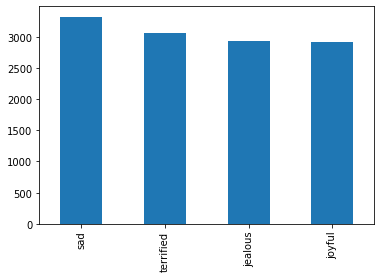

In [8]:
train['context'].value_counts().plot('bar')

## Create a sparse bag-of-words (BOW) presentation

In [9]:
def tokenize(sentence):    
    words = re.sub("[^a-z]", " ",  sentence.lower()).split()      
    words = list(set(words))
    return words
print (tokenize(train.iloc[0,0]))

['me', 'a', 'under', 'interviews', 'microscope', 'makes', 'to', 'uncomfortable', 'at', 'bullets', 'general', 'that', 'in', 'sweat', 'always', 'make', 'comma', 'like', 'looked', 'job', 'be']


In [10]:
train['word_list'] = train['utterance'].apply(tokenize)
train.head()

,utterance,context,word_list
0,Job interviews always make me sweat bullets_co...,terrified,"[me, a, under, interviews, microscope, makes, ..."
1,Don't be nervous. Just be prepared.,terrified,"[prepared, just, don, nervous, be, t]"
2,I feel like getting prepared and then having a...,terrified,"[at, prepared, thrown, curve, off, like, throw..."
3,Yes but if you stay calm it will be ok.,terrified,"[but, stay, ok, if, yes, it, be, calm, will, you]"
4,It's hard to stay clam. How do you do it?,terrified,"[clam, s, do, stay, to, it, hard, you, how]"


In [0]:
v = DictVectorizer()
X = v.fit_transform(Counter(row['word_list']) for _, row in train.iterrows())

In [12]:
print (X.A)
print (X.shape)
print (X.max())

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(12250, 7235)
1.0


In [13]:
print (v.vocabulary_)

{'me': 3984, 'a': 0, 'under': 6739, 'interviews': 3386, 'microscope': 4055, 'makes': 3897, 'to': 6508, 'uncomfortable': 6737, 'at': 357, 'bullets': 843, 'general': 2685, 'that': 6409, 'in': 3281, 'sweat': 6254, 'always': 195, 'make': 3896, 'comma': 1231, 'like': 3735, 'looked': 3806, 'job': 3490, 'be': 527, 'prepared': 4890, 'just': 3536, 'don': 1876, 'nervous': 4278, 't': 6291, 'thrown': 6469, 'curve': 1544, 'off': 4403, 'throws': 6470, 'ball': 472, 'feel': 2365, 'and': 211, 'getting': 2706, 'having': 2976, 'i': 3218, 'you': 7208, 'then': 6423, 'but': 873, 'stay': 6050, 'ok': 4419, 'if': 3232, 'yes': 7197, 'it': 3439, 'calm': 899, 'will': 7058, 'clam': 1135, 's': 5436, 'do': 1853, 'hard': 2941, 'how': 3162, 'over': 4507, 'enginering': 2111, 'the': 6411, 'was': 6944, 'school': 5516, 'hi': 3046, 'students': 6151, 'year': 7189, 'this': 6442, 'first': 2442, 'my': 4211, 'what': 7010, 'great': 2821, 'major': 3895, 'so': 5877, 'sounds': 5938, 'your': 7213, 'computer': 1282, 'proud': 4977, 'a

In [0]:
v.vocabulary_rev_ = dict((value,key) for key,value in v.vocabulary_.items())

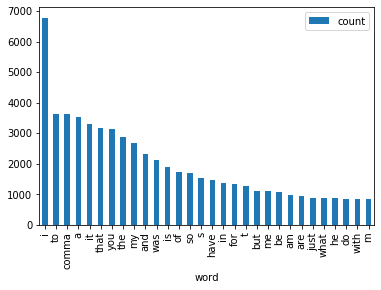

In [15]:
def show_top_words(dist, vocab):
    df = pd.DataFrame(dist,columns = ['count']).reset_index()
    df['word'] = df['index'].map(vocab)
    df.sort_values('count',ascending=False).head(30)[['word','count']].plot(x='word',y='count',kind='bar')
show_top_words(np.sum(X, axis=0).tolist()[0], v.vocabulary_rev_)

## BOW with NLTK

In [16]:
stop_words = set(stopwords.words('english'))
#stop_words.update(["comma","wa","get","oh","got","go"])
stop_words.update(["comma"])
lemmatizer = WordNetLemmatizer()

def nltk_tokenize(sentence):
    sentence = sentence.lower().replace('_',' ')
    words = word_tokenize(sentence)
    words = [lemmatizer.lemmatize(w) for w in words if w.isalpha()]
    words = [w for w in words if w not in stop_words]
    return list(set(words))
    
print (nltk_tokenize(train.iloc[0,0]))

['sweat', 'microscope', 'always', 'make', 'like', 'looked', 'general', 'bullet', 'interview', 'job', 'uncomfortable']


In [17]:
train['nltk_word_list'] = train['utterance'].apply(nltk_tokenize)
train.head()

,utterance,context,word_list,nltk_word_list
0,Job interviews always make me sweat bullets_co...,terrified,"[me, a, under, interviews, microscope, makes, ...","[sweat, microscope, always, make, like, looked..."
1,Don't be nervous. Just be prepared.,terrified,"[prepared, just, don, nervous, be, t]","[prepared, nervous]"
2,I feel like getting prepared and then having a...,terrified,"[at, prepared, thrown, curve, off, like, throw...","[prepared, thrown, curve, throw, like, ball, f..."
3,Yes but if you stay calm it will be ok.,terrified,"[but, stay, ok, if, yes, it, be, calm, will, you]","[ok, yes, stay, calm]"
4,It's hard to stay clam. How do you do it?,terrified,"[clam, s, do, stay, to, it, hard, you, how]","[clam, hard, stay]"


In [0]:
v_nltk = DictVectorizer()
X_nltk = v_nltk.fit_transform(Counter(row['nltk_word_list']) for _, row in train.iterrows())

In [19]:
print (X_nltk.A)
print (X_nltk.shape)
print (X.max())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(12250, 6309)
1.0


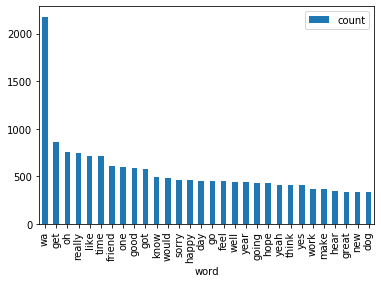

In [20]:
v_nltk.vocabulary_rev_ = dict((value,key) for key,value in v_nltk.vocabulary_.items())
show_top_words(np.sum(X_nltk, axis=0).tolist()[0], v_nltk.vocabulary_rev_)

## Normalization

In [21]:
vectorizer = TfidfTransformer()
X_norm = vectorizer.fit_transform(X_nltk)
print (X_norm)

  (0, 5896)	0.37817377817787823
  (0, 5491)	0.3574345372336066
  (0, 3540)	0.39463543981019
  (0, 3402)	0.18280172522847127
  (0, 3328)	0.29547748594205503
  (0, 3266)	0.1558890167420118
  (0, 3061)	0.2072640709270408
  (0, 2969)	0.33357072011072236
  (0, 2348)	0.32189098530819005
  (0, 727)	0.3664940433753459
  (0, 173)	0.19053530666631777
  (1, 4268)	0.7649540496478454
  (1, 3729)	0.6440848561543436
  (2, 5666)	0.4274228352514051
  (2, 5664)	0.4009255767947816
  (2, 4268)	0.37540462135530095
  (2, 3266)	0.18180520727368168
  (2, 2367)	0.2501668423709629
  (2, 2070)	0.2037956344282253
  (2, 1333)	0.4602426741261015
  (2, 417)	0.40822446022999737
  (3, 6280)	0.3456465930279408
  (3, 5311)	0.470156939964998
  (3, 3855)	0.4673721115280015
  (3, 778)	0.6641115824142684
  :	:
  (12246, 4038)	0.3426790481728674
  (12246, 3719)	0.3201763351565446
  (12246, 404)	0.24484752874547677
  (12247, 5450)	0.5678903412702191
  (12247, 4831)	0.4312368671043352
  (12247, 3849)	0.3300710362850522
  (1224

## Classifier

In [22]:
test_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/empatheticdialogues/test.csv",sep=",",quoting=csv.QUOTE_NONE)
test = prepare_data(test_raw)
test['nltk_word_list'] = test['utterance'].apply(nltk_tokenize)
test_X_nltk = v_nltk.transform(Counter(row['nltk_word_list']) for _, row in test.iterrows())
test_X_norm = vectorizer.transform(test_X_nltk)
print (test.shape)
test.head()

(1382, 3)


,utterance,context,nltk_word_list
0,I'm so sad because i've read an article about ...,sad,"[article, doctor, sad, girl, medication, read,..."
1,Ugh_comma_ those articles always get me too......,sad,"[article, always, wrong, get, ugh, wa]"
2,she was born premature at home_comma_ she had ...,sad,"[doctor, born, home, breathing, taking, instea..."
3,Jeez! Its so unfortunate... very sad really.,sad,"[really, unfortunate, sad, jeez]"
4,yes! And i do believe in God and prayers but g...,sad,"[take, hospital, doctor, prayer, goodness, ple..."


In [23]:
clf = SGDClassifier(random_state = 0, loss = 'log', max_iter = 100)
clf.fit(X_norm, train['context'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [0]:
def output_model_result(model, test_X, y):
    y_predict = model.predict(test_X)
    print ("Accuracy Score: %2.1f%%"%(accuracy_score(y,y_predict)*100.0))
    print ("F1 Score:")
    f1_list = f1_score(y,y_predict,average=None,labels=['sad', 'jealous', 'joyful', 'terrified'])
    print (f1_list)
    print ("Avg F1 Score: %2.1f%%"%(sum(f1_list)/len(f1_list)*100.0))
    print ("Confusion Matrix: ")
    cm = confusion_matrix(y,y_predict,labels=['sad', 'jealous', 'joyful', 'terrified'])
    print (cm)
    print ("Normalized Confusion Matrix: ")
    cm_norm = (cm/(cm.dot(np.ones((4,1)))))
    print (cm_norm)

In [25]:
output_model_result(clf,X_norm, train['context']) #train set result

Accuracy Score: 76.0%
F1 Score:
[0.74252566 0.74588477 0.75735797 0.79331257]
Avg F1 Score: 76.0%
Confusion Matrix: 
[[2496  301  262  268]
 [ 325 2175  268  162]
 [ 278  251 2213  182]
 [ 297  175  177 2420]]
Normalized Confusion Matrix: 
[[0.75022543 0.0904719  0.07874962 0.08055305]
 [0.1109215  0.74232082 0.09146758 0.0552901 ]
 [0.09507524 0.08584131 0.75683995 0.0622435 ]
 [0.09677419 0.05702183 0.05767351 0.78853047]]


In [26]:
output_model_result(clf,test_X_norm, test['context']) #test set result

Accuracy Score: 63.3%
F1 Score:
[0.62418726 0.5852187  0.62857143 0.69936709]
Avg F1 Score: 63.4%
Confusion Matrix: 
[[240  41  47  46]
 [ 63 194  59  38]
 [ 59  48 220  29]
 [ 33  26  18 221]]
Normalized Confusion Matrix: 
[[0.64171123 0.10962567 0.12566845 0.12299465]
 [0.1779661  0.5480226  0.16666667 0.10734463]
 [0.16573034 0.13483146 0.61797753 0.08146067]
 [0.11073826 0.08724832 0.06040268 0.74161074]]


In [27]:
test['predicted'] = clf.predict(test_X_norm)
test[test['predicted'] != test['context']].head(10)

,utterance,context,nltk_word_list,predicted
2,she was born premature at home_comma_ she had ...,sad,"[doctor, born, home, breathing, taking, instea...",terrified
4,yes! And i do believe in God and prayers but g...,sad,"[take, hospital, doctor, prayer, goodness, ple...",terrified
6,3 years is a long time. How come?,joyful,"[long, time, come, year]",sad
8,Oh I see. They must miss you_comma_ too.,joyful,"[must, see, miss, oh]",sad
14,She was around 11_comma_ so she took it very h...,sad,"[around, knew, home, school, took, went, stay,...",terrified
16,One of the saddest things to me is when people...,sad,"[underestimate, thing, people, capable, one, s...",jealous
18,That's perfectly natural. You sound like the k...,sad,"[come, though, quickly, like, bearing, perfect...",jealous
20,I met up with an old flame recently_comma_ did...,jealous,"[met, expected, go, old, flame, recently]",sad
21,Oh ya? What happened?? I'm intrigued,jealous,"[happened, ya, intrigued, oh]",terrified
23,Woah plot twist. She brought him along to meet...,jealous,"[twist, along, meet, woah, plot, brought]",joyful


In [0]:
def get_missing_word_percent(word_list, vocab):
    count = 0
    missing_count = 0
    for w in word_list:
        count += 1
        if w not in vocab:
            missing_count += 1
    if count == 0:
        return 0
    return float(missing_count)/float(count)

In [29]:
test['missing_percent'] = test['nltk_word_list'].map(lambda x: get_missing_word_percent(x, v_nltk.vocabulary_))
test[test['predicted'] != test['context']].head(10)

,utterance,context,nltk_word_list,predicted,missing_percent
2,she was born premature at home_comma_ she had ...,sad,"[doctor, born, home, breathing, taking, instea...",terrified,0.083333
4,yes! And i do believe in God and prayers but g...,sad,"[take, hospital, doctor, prayer, goodness, ple...",terrified,0.076923
6,3 years is a long time. How come?,joyful,"[long, time, come, year]",sad,0.000000
8,Oh I see. They must miss you_comma_ too.,joyful,"[must, see, miss, oh]",sad,0.000000
14,She was around 11_comma_ so she took it very h...,sad,"[around, knew, home, school, took, went, stay,...",terrified,0.000000
16,One of the saddest things to me is when people...,sad,"[underestimate, thing, people, capable, one, s...",jealous,0.333333
18,That's perfectly natural. You sound like the k...,sad,"[come, though, quickly, like, bearing, perfect...",jealous,0.142857
20,I met up with an old flame recently_comma_ did...,jealous,"[met, expected, go, old, flame, recently]",sad,0.000000
21,Oh ya? What happened?? I'm intrigued,jealous,"[happened, ya, intrigued, oh]",terrified,0.250000
23,Woah plot twist. She brought him along to meet...,jealous,"[twist, along, meet, woah, plot, brought]",joyful,0.333333


In [30]:
test.sort_values('missing_percent',ascending=False).head(10)

,utterance,context,nltk_word_list,predicted,missing_percent
81,Justin Beiber.,jealous,"[justin, beiber]",terrified,1.000000
571,That is infair,jealous,[infair],terrified,1.000000
545,I am very excited for the arrival of our 7th g...,joyful,"[grandbaby, arrival, excited]",joyful,0.666667
98,Someone should have sued them.,sad,"[sued, someone]",terrified,0.500000
1078,i like paprika in my mac and cheese,joyful,"[like, mac, cheese, paprika]",joyful,0.500000
168,Thank you for your solidarity,sad,"[solidarity, thank]",joyful,0.500000
915,I named her Layla.,joyful,"[layla, named]",joyful,0.500000
575,Do you smack the women who do it?,jealous,"[smack, woman]",jealous,0.500000
306,If I had dispensible funds like that_comma_ th...,joyful,"[definitely, pillow, ala, like, fund, guy, pri...",jealous,0.500000
704,Emerged from a bathroom? Intiguing. What do yo...,sad,"[bathroom, intiguing, emerged, mean]",jealous,0.500000


In [31]:
p = 0.2
print (test[test['missing_percent']>=p].shape[0])
print (test.shape[0])
print ("Accuracy Score when missing_percent >= %.1f: %2.1f%%"%(p,accuracy_score(test[test['missing_percent']>=p]['context'],test[test['missing_percent']>=p]['predicted'])*100))

138
1382
Accuracy Score when missing_percent >= 0.2: 44.9%


## Pretrained Model - wordToVec

In [0]:
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
from tqdm import tqdm
#tqdm.pandas(desc="progress-bar")


In [33]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [34]:
model.most_similar('question')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('questions', 0.7561894655227661),
 ('unasked_question', 0.6627503633499146),
 ('quesiton', 0.6254581212997437),
 ('unanswerable_question', 0.6157240271568298),
 ('quesion', 0.6034299731254578),
 ('answer', 0.5857622623443604),
 ('Questions', 0.5840161442756653),
 ('Question', 0.5829653739929199),
 ('queston', 0.5682158470153809),
 ('conundrum', 0.5641218423843384)]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 300

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer(analyzer=lambda x: x,min_df=3)
        tfidf.fit(X)
        default_idf = float(sum(tfidf.idf_))/float(len(tfidf.idf_))
        self.word2weight = defaultdict(
            lambda: default_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X])

In [0]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #for words in X:
        #  for w in words:
        #    if (w not in self.word2vec) and (len(w.split("_")) == 1):
        #        print ("Not in word2vec:" + w)
        #    if (w in self.word2vec) and (len(w.split("_")) > 1):
        #        print ("Phases in word2vec:" + w)
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X])

In [37]:
from nltk.util import everygrams
import re

stop_words = set(stopwords.words('english'))
#stop_words.update(["comma","wa","get","oh","got","go"])
stop_words.update(["comma",".",","])
stop_words.remove("not")

lemmatizer = WordNetLemmatizer()
spell = Speller(lang='en')
def ngram_tokenize(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace(".", " ")\
        .replace('_',' ')\
        .replace(". . .", " ... ")\
        .replace(",", " ")\
        .replace(";", " ")\
        .replace(":", " ")\
        .replace("!", " ! ")\
        .replace("n't",' not')\
        .replace('"', " ")\
        .replace("?", " ")
    sentence = re.sub(r'\$[0-9]+',"<dollar>",sentence)
    sentence = re.sub(r'[0-9]+(\s)?dollar(s)?',"<dollar>",sentence)
    sentence = re.sub(r'[0-9]+',"<number>",sentence)
    sentence = re.sub(r"\'[a-z]\S*","",sentence)
    words = sentence.lower().split()
    words = [spell(lemmatizer.lemmatize(w)) for w in words]
    words = [w for w in words if w not in stop_words]
    return ["_".join(x) for x in (everygrams(words, max_len=3))]
    
print (ngram_tokenize(train.iloc[1,0]))
print (ngram_tokenize("I have $5 in linda's pocket or 5 dollar in my hand. That's simply awesome. We've been friend. "))

['not', 'nervous', 'prepared', 'not_nervous', 'nervous_prepared', 'not_nervous_prepared']
['<dollar>', 'linda', 'pocket', '<dollar>', 'hand', 'simply', 'awesome', 'friend', '<dollar>_linda', 'linda_pocket', 'pocket_<dollar>', '<dollar>_hand', 'hand_simply', 'simply_awesome', 'awesome_friend', '<dollar>_linda_pocket', 'linda_pocket_<dollar>', 'pocket_<dollar>_hand', '<dollar>_hand_simply', 'hand_simply_awesome', 'simply_awesome_friend']


In [38]:
train['ngram_word_list'] = train['utterance'].apply(ngram_tokenize)
test['ngram_word_list'] = test['utterance'].apply(ngram_tokenize)
train.head()

,utterance,context,word_list,nltk_word_list,ngram_word_list
0,Job interviews always make me sweat bullets_co...,terrified,"[me, a, under, interviews, microscope, makes, ...","[sweat, microscope, always, make, like, looked...","[job, interview, always, make, sweat, bullet, ..."
1,Don't be nervous. Just be prepared.,terrified,"[prepared, just, don, nervous, be, t]","[prepared, nervous]","[not, nervous, prepared, not_nervous, nervous_..."
2,I feel like getting prepared and then having a...,terrified,"[at, prepared, thrown, curve, off, like, throw...","[prepared, thrown, curve, throw, like, ball, f...","[feel, like, getting, prepared, curve, ball, t..."
3,Yes but if you stay calm it will be ok.,terrified,"[but, stay, ok, if, yes, it, be, calm, will, you]","[ok, yes, stay, calm]","[yes, stay, calm, ok, yes_stay, stay_calm, cal..."
4,It's hard to stay clam. How do you do it?,terrified,"[clam, s, do, stay, to, it, hard, you, how]","[clam, hard, stay]","[hard, stay, clam, hard_stay, stay_clam, hard_..."


In [39]:
#pca = PCA(.95)

v_w2v = TfidfEmbeddingVectorizer(model)
#v_w2v = MeanEmbeddingVectorizer(model)
v_w2v.fit(Counter(row['ngram_word_list']) for _, row in train.iterrows())
X_w2v = v_w2v.transform(Counter(row['ngram_word_list']) for _, row in train.iterrows())
scaler = StandardScaler()
scaler.fit(X_w2v)
X_w2v = scaler.transform(X_w2v)
#pca.fit(X_w2v)
#X_w2v = pca.transform(X_w2v)
#scaler_2 = StandardScaler()
#scaler_2.fit(X_w2v)
#X_w2v = scaler_2.transform(X_w2v)
test_X_w2v = v_w2v.transform(Counter(row['ngram_word_list']) for _, row in test.iterrows())
test_X_w2v = scaler.transform(test_X_w2v)
#test_X_w2v = pca.transform(test_X_w2v)
#test_X_w2v = scaler_2.transform(test_X_w2v)
print (X_w2v.shape)
print (X_w2v)
#print (X_w2v.mean(axis=0))

(12250, 300)
[[ 0.02564317  0.97136281 -0.22898353 ...  0.20271974 -1.63857973
   0.55596588]
 [-0.57877482  0.204968    0.02967761 ...  1.45012536  0.72985862
  -1.27589666]
 [ 0.61380251 -0.22577783 -0.49049709 ...  1.21560839 -1.34098993
  -0.70890491]
 ...
 [ 0.02317245 -0.43304879  1.24072393 ... -0.50962696 -0.23966933
   0.51344273]
 [-0.02067862  0.25225956  0.05360792 ...  0.55242543  0.40051408
  -0.2037254 ]
 [-0.63566778 -0.4569332   0.89808284 ... -0.82647571 -0.42966578
  -0.44090499]]


In [40]:
tfidf_2 = TfidfVectorizer(analyzer=lambda x: x,min_df=3)
tfidf_2.fit(Counter(row['ngram_word_list']) for _, row in train.iterrows())
X_bow = tfidf_2.transform(Counter(row['ngram_word_list']) for _, row in train.iterrows())
print (X_w2v.shape)
print (X_bow.shape)

(12250, 300)
(12250, 6766)


In [41]:
max(tfidf_2.idf_)

9.02706848417428

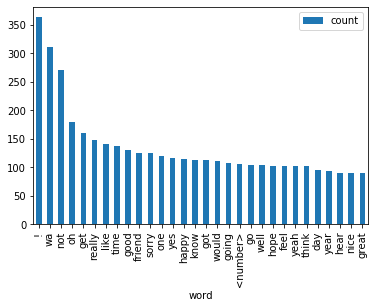

In [42]:
tfidf_2.vocabulary_rev_ = dict((value,key) for key,value in tfidf_2.vocabulary_.items())
show_top_words(np.sum(X_bow, axis=0).tolist()[0], tfidf_2.vocabulary_rev_)

In [0]:
X_combined = np.append(X_w2v, X_bow.A, axis=1)
test_X_bow = tfidf_2.transform(Counter(row['ngram_word_list']) for _, row in test.iterrows())
test_X_combined = np.append(test_X_w2v, test_X_bow.A, axis=1)

In [0]:
#X_combined = np.append(X_w2v, X_norm.A, axis=1)
#test_X_combined = np.append(test_X_w2v, test_X_norm.A, axis=1)

In [45]:
print (X_combined.shape)
print (X_combined)

(12250, 7066)
[[ 0.02564317  0.97136281 -0.22898353 ...  0.          0.
   0.        ]
 [-0.57877482  0.204968    0.02967761 ...  0.          0.
   0.        ]
 [ 0.61380251 -0.22577783 -0.49049709 ...  0.          0.
   0.        ]
 ...
 [ 0.02317245 -0.43304879  1.24072393 ...  0.          0.
   0.        ]
 [-0.02067862  0.25225956  0.05360792 ...  0.          0.
   0.        ]
 [-0.63566778 -0.4569332   0.89808284 ...  0.          0.
   0.        ]]


In [46]:
#from sklearn.neural_network import MLPClassifier
#from sklearn.model_selection import GridSearchCV
#mlp = MLPClassifier(random_state = 2019)

#mlp_param_grid = {
#    'hidden_layer_sizes':[(10,10),(16,),(20,20)],
#    'activation':['tanh','relu'],
#    'solver':['adam'],
#    'alpha':[0.01,0.5,0.002,0.7],
#    'learning_rate':['constant'],
#    'max_iter':[200],
#    'early_stopping':[False,True]
#}

gsMLP = GridSearchCV(mlp, param_grid = mlp_param_grid, cv = 5, scoring = 'f1_weighted', n_jobs= 4, verbose = 1)
gsMLP.fit(X_combined,train['context'])
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

In [49]:
final_mlp = MLPClassifier(hidden_layer_sizes=(10,10), activation='tanh',alpha = 0.7, random_state = 2019,early_stopping=True, verbose = 1)
final_mlp.fit(X_combined,train['context'])

Iteration 1, loss = 1.19375812
Validation score: 0.594286
Iteration 2, loss = 0.99952674
Validation score: 0.610612
Iteration 3, loss = 0.94856464
Validation score: 0.618776
Iteration 4, loss = 0.92231588
Validation score: 0.616327
Iteration 5, loss = 0.90696087
Validation score: 0.625306
Iteration 6, loss = 0.89707587
Validation score: 0.623673
Iteration 7, loss = 0.88697460
Validation score: 0.627755
Iteration 8, loss = 0.87976239
Validation score: 0.627755
Iteration 9, loss = 0.87457116
Validation score: 0.629388
Iteration 10, loss = 0.86988062
Validation score: 0.619592
Iteration 11, loss = 0.86297965
Validation score: 0.622857
Iteration 12, loss = 0.85843667
Validation score: 0.635918
Iteration 13, loss = 0.85437100
Validation score: 0.630204
Iteration 14, loss = 0.85132164
Validation score: 0.631837
Iteration 15, loss = 0.84708705
Validation score: 0.629388
Iteration 16, loss = 0.84318086
Validation score: 0.622857
Iteration 17, loss = 0.83896419
Validation score: 0.628571
Iterat

MLPClassifier(activation='tanh', alpha=0.7, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=1, warm_start=False)

In [50]:
output_model_result(final_mlp,X_combined, train['context'])

Accuracy Score: 72.3%
F1 Score:
[0.69869931 0.699481   0.72044459 0.77634622]
Avg F1 Score: 72.4%
Confusion Matrix: 
[[2283  412  350  282]
 [ 338 2089  332  171]
 [ 279  324 2139  182]
 [ 308  218  193 2350]]
Normalized Confusion Matrix: 
[[0.68620379 0.12383529 0.10519988 0.08476105]
 [0.11535836 0.71296928 0.11331058 0.05836177]
 [0.09541724 0.11080711 0.73153215 0.0622435 ]
 [0.10035842 0.07103291 0.06288693 0.76572173]]


In [51]:
output_model_result(final_mlp,test_X_combined, test['context'])

Accuracy Score: 63.0%
F1 Score:
[0.61394102 0.56565657 0.63428571 0.7136    ]
Avg F1 Score: 63.2%
Confusion Matrix: 
[[229  65  40  40]
 [ 63 196  59  36]
 [ 51  55 222  28]
 [ 29  23  23 223]]
Normalized Confusion Matrix: 
[[0.61229947 0.17379679 0.10695187 0.10695187]
 [0.1779661  0.55367232 0.16666667 0.10169492]
 [0.14325843 0.15449438 0.62359551 0.07865169]
 [0.09731544 0.07718121 0.07718121 0.74832215]]
